### UFC Fight Prediction
Author: Shawn Balgobind

This Program uses a csv data set of all UFC fights ever to train a random forest and a XGboost prediction models. It is trained off of "Ultimate UFC Dataset" from Kaggle.

**Key Features:**

*   **Base Fight Features:** These are fundamental, pre-calculated features from the original dataset that describe the context of the fight and the basic physical and record differences between the competitors.
    *   **TitleBout:** A binary feature indicating if the fight is for a championship title (1 for True, 0 for False).
    *   **NumberOfRounds:** The scheduled number of rounds for the fight (typically 3 or 5).
    *   **AgeDif:** The age difference between the Red and Blue fighters.
    *   **HeightDif:** The height difference (in cms) between the Red and Blue fighters.
    *   **ReachDif:** The reach difference (in cms) between the Red and Blue fighters.
    *   **WinStreakDif:** The difference in the fighters' current winning streaks.

*   **Advanced Engineered Features (EWMA-based):** These are sophisticated features calculated in the notebook to capture a fighter's recent form and style. They are all based on an Exponentially Weighted Moving Average (EWMA), which gives more weight to more recent fights.
    *   **ewma_sig_str_dif:** The difference in the recency-weighted average of significant strikes landed per fight. It captures which fighter is in better striking form recently.
    *   **ewma_td_dif:** The difference in the recency-weighted average of takedowns landed per fight. It measures which fighter has been more successful with their wrestling lately.
    *   **schedule_dif:** The difference in the recency-weighted "strength of schedule," calculated from opponent ranks. A negative value suggests the Red fighter has faced tougher opponents recently.
    *   **style_dif:** The difference in the recency-weighted "style ratio" (strikes vs. takedowns). This feature quantifies the matchup between a recent striker and a recent grappler.
    *   **finishing_rate_dif:** The difference in the recency-weighted rate of finishing fights (KO + Submission). It measures which fighter has been more decisively winning their recent bouts.

*   **Categorical Feature Transformation:** This is how the weight class is handled:
    *   **WeightClass:** This feature is not used as a single column with numerical values. Instead, it is One-Hot Encoded. This process transforms the single WeightClass column into multiple new binary (0 or 1) columns, with one for each weight class (e.g., WC_Welterweight, WC_Lightweight, WC_Heavyweight, etc.). This allows the model to treat each weight class as a distinct category without assuming a false numerical order (Heavyweight is superior to Lightweight etc. Important for fighters who moved classes during their career).



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import randint, uniform
import warnings


warnings.filterwarnings('ignore')

# Set plot style and options
plt.style.use('seaborn-v0_8-whitegrid')
pd.options.mode.chained_assignment = None # Suppress SettingWithCopyWarning

#### 1. Data Loading and Initial Preparation

In [2]:
try:
    file_path = 'data/raw/ufc_complete_dataset.csv'
    df = pd.read_csv(file_path)
    
    # Convert to datetime and sort chronologically. This is ESSENTIAL for all subsequent steps.
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date').reset_index(drop=True)
    
    # Drop rows with no winner or draws early on
    df.dropna(subset=['Winner'], inplace=True)
    df = df[df['Winner'].isin(['Red', 'Blue'])]
    
    print(f"Dataset loaded and sorted. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}.")
    df = None

Dataset loaded and sorted. Shape: (6528, 118)


#### 2. Advanced Feature Engineering

This is the most critical new section. We will create fighter-centric historical stats using EWMA. The key challenge is to calculate these stats for every fight *without leaking information from the fight itself*. We achieve this by calculating the metric for all past fights and then using `.shift(1)` to get the value *before* the current fight.

In [3]:
# To calculate fighter-specific stats, we create a long-form DataFrame
cols_to_keep = ['Date', 'RedFighter', 'BlueFighter', 'Winner', 'RMatchWCRank', 'BMatchWCRank', 
                'RedAvgSigStrLanded', 'BlueAvgSigStrLanded', 'RedAvgTDLanded', 'BlueAvgTDLanded',
                'RedWinsByKO', 'RedWinsBySubmission', 'RedWins', 'BlueWinsByKO', 'BlueWinsBySubmission', 'BlueWins']
red_fights = df[['Date', 'RedFighter', 'BlueFighter', 'RMatchWCRank', 'BMatchWCRank', 'RedAvgSigStrLanded', 'RedAvgTDLanded', 'RedWinsByKO', 'RedWinsBySubmission', 'RedWins']].rename(columns={'RedFighter': 'Fighter', 'BlueFighter': 'Opponent', 'RMatchWCRank': 'Fighter_Rank', 'BMatchWCRank': 'Opponent_Rank', 'RedAvgSigStrLanded': 'AvgSigStr', 'RedAvgTDLanded': 'AvgTD', 'RedWinsByKO': 'WinsByKO', 'RedWinsBySubmission': 'WinsBySub', 'RedWins': 'TotalWins'})
red_fights['Corner'] = 'Red'

blue_fights = df[['Date', 'BlueFighter', 'RedFighter', 'BMatchWCRank', 'RMatchWCRank', 'BlueAvgSigStrLanded', 'BlueAvgTDLanded', 'BlueWinsByKO', 'BlueWinsBySubmission', 'BlueWins']].rename(columns={'BlueFighter': 'Fighter', 'RedFighter': 'Opponent', 'BMatchWCRank': 'Fighter_Rank', 'RMatchWCRank': 'Opponent_Rank', 'BlueAvgSigStrLanded': 'AvgSigStr', 'BlueAvgTDLanded': 'AvgTD', 'BlueWinsByKO': 'WinsByKO', 'BlueWinsBySubmission': 'WinsBySub', 'BlueWins': 'TotalWins'})
blue_fights['Corner'] = 'Blue'

fighter_df = pd.concat([red_fights, blue_fights]).sort_values(by='Date').reset_index(drop=True)

# Fill NaNs for calculation purposes
fighter_df['Opponent_Rank'].fillna(99, inplace=True)
epsilon = 1e-6 # To avoid division by zero

# --- Calculate Advanced Features ---
fighter_df_grouped = fighter_df.groupby('Fighter')

# EWMA for key stats (alpha=0.5 means we weigh recent fights more heavily)
fighter_df['ewma_sig_str'] = fighter_df_grouped['AvgSigStr'].transform(lambda x: x.ewm(alpha=0.5).mean().shift(1))
fighter_df['ewma_td'] = fighter_df_grouped['AvgTD'].transform(lambda x: x.ewm(alpha=0.5).mean().shift(1))

# Strength of Schedule (EWMA of opponent ranks)
fighter_df['strength_of_schedule'] = fighter_df_grouped['Opponent_Rank'].transform(lambda x: x.ewm(alpha=0.5).mean().shift(1))

# Fight Style Archetype (Striking vs Grappling ratio)
fighter_df['style_ratio'] = (fighter_df['AvgSigStr'] + epsilon) / (fighter_df['AvgTD'] + epsilon)
fighter_df['ewma_style_ratio'] = fighter_df_grouped['style_ratio'].transform(lambda x: x.ewm(alpha=0.5).mean().shift(1))

# Finishing Rate 
fighter_df['finishing_rate'] = (fighter_df['WinsByKO'] + fighter_df['WinsBySub']) / (fighter_df['TotalWins'] + epsilon)
fighter_df['ewma_finishing_rate'] = fighter_df_grouped['finishing_rate'].transform(lambda x: x.ewm(alpha=0.5).mean().shift(1))

# --- Merge new features back into the main DataFrame ---
# Merge for Red corner fighters
red_features = fighter_df[fighter_df['Corner'] == 'Red']
df = pd.merge(df, red_features[['Date', 'Fighter', 'ewma_sig_str', 'ewma_td', 'strength_of_schedule', 'ewma_style_ratio', 'ewma_finishing_rate']], left_on=['Date', 'RedFighter'], right_on=['Date', 'Fighter'], how='left')
df = df.rename(columns={'ewma_sig_str': 'R_ewma_sig_str', 'ewma_td': 'R_ewma_td', 'strength_of_schedule': 'R_strength_of_schedule', 'ewma_style_ratio': 'R_style_ratio', 'ewma_finishing_rate': 'R_finishing_rate'}).drop(columns=['Fighter'])

# Merge for Blue corner fighters
blue_features = fighter_df[fighter_df['Corner'] == 'Blue']
df = pd.merge(df, blue_features[['Date', 'Fighter', 'ewma_sig_str', 'ewma_td', 'strength_of_schedule', 'ewma_style_ratio', 'ewma_finishing_rate']], left_on=['Date', 'BlueFighter'], right_on=['Date', 'Fighter'], how='left')
df = df.rename(columns={'ewma_sig_str': 'B_ewma_sig_str', 'ewma_td': 'B_ewma_td', 'strength_of_schedule': 'B_strength_of_schedule', 'ewma_style_ratio': 'B_style_ratio', 'ewma_finishing_rate': 'B_finishing_rate'}).drop(columns=['Fighter'])

# Create differentials from the new EWMA features
df['ewma_sig_str_dif'] = df['R_ewma_sig_str'] - df['B_ewma_sig_str']
df['ewma_td_dif'] = df['R_ewma_td'] - df['B_ewma_td']
df['schedule_dif'] = df['R_strength_of_schedule'] - df['B_strength_of_schedule'] # Lower is better, so a negative diff means Red has the harder schedule
df['style_dif'] = df['R_style_ratio'] - df['B_style_ratio']
df['finishing_rate_dif'] = df['R_finishing_rate'] - df['B_finishing_rate']


#### 3. Final Preprocessing & Feature Selection
Now we select our final feature set, including the powerful new engineered features, and prepare the data for the model.

In [4]:
TARGET = 'Winner'
BASE_FEATURES = [
    'TitleBout', 'NumberOfRounds', 'WeightClass',
    'AgeDif', 'HeightDif', 'ReachDif', 'WinStreakDif'
]

NEW_FEATURES = [
    'ewma_sig_str_dif', 'ewma_td_dif', 'schedule_dif', 'style_dif', 'finishing_rate_dif'
]

FINAL_FEATURES = BASE_FEATURES + NEW_FEATURES

model_df = df[[TARGET] + FINAL_FEATURES].copy()

# --- Preprocessing Pipeline ---
# One-Hot Encode WeightClass
model_df = pd.get_dummies(model_df, columns=['WeightClass'], prefix='WC', drop_first=True)

# Impute missing values. New EWMA features will have NaNs for a fighter's first fight.
for col in model_df.select_dtypes(include=np.number).columns:
    model_df[col].fillna(model_df[col].median(), inplace=True)

# Encode Target Variable
model_df['Winner_encoded'] = model_df[TARGET].apply(lambda x: 1 if x == 'Red' else 0)

# Define final X and y
X = model_df.drop(columns=[TARGET, 'Winner_encoded'])
y = model_df['Winner_encoded']

print("Final feature set prepared.")
print(f"Final data shape for modeling: {X.shape}")

Final feature set prepared.
Final data shape for modeling: (6528, 23)


#### 4. Model Training and Hyperparameter Tuning

We will use `TimeSeriesSplit` for cross-validation to ensure we always train on past data to predict future data. We then use `RandomizedSearchCV` to find the best hyperparameters for both Random Forest and XGBoost.

In [5]:
# Define the cross-validation strategy
tscv = TimeSeriesSplit(n_splits=5)

# --- Random Forest Tuning ---
print("--- Tuning Random Forest ---")
rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 20),
    'min_samples_leaf': randint(2, 10),
    'min_samples_split': randint(2, 10),
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
random_search_rf = RandomizedSearchCV(
    rf, param_distributions=rf_param_dist, n_iter=50, cv=tscv, 
    scoring='accuracy', random_state=42, verbose=1, n_jobs=-1
)
random_search_rf.fit(X, y)

print(f"Best RF Accuracy: {random_search_rf.best_score_:.4f}")
print(f"Best RF Params: {random_search_rf.best_params_}")
best_rf = random_search_rf.best_estimator_

--- Tuning Random Forest ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best RF Accuracy: 0.5833
Best RF Params: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 161}


In [6]:
# --- XGBoost Tuning ---
print("\n--- Tuning XGBoost ---")
xgb_param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': randint(0, 5)
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
random_search_xgb = RandomizedSearchCV(
    xgb_model, param_distributions=xgb_param_dist, n_iter=50, cv=tscv, 
    scoring='accuracy', random_state=42, verbose=1, n_jobs=-1
)
random_search_xgb.fit(X, y)

print(f"Best XGBoost Accuracy: {random_search_xgb.best_score_:.4f}")
print(f"Best XGBoost Params: {random_search_xgb.best_params_}")
best_xgb = random_search_xgb.best_estimator_


--- Tuning XGBoost ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost Accuracy: 0.5838
Best XGBoost Params: {'colsample_bytree': np.float64(0.7888820517112247), 'gamma': 4, 'learning_rate': np.float64(0.024910128735954166), 'max_depth': 9, 'n_estimators': 108, 'subsample': np.float64(0.9316734307889971)}


#### 5. Final Evaluation and Feature Importance

After tuning, we compare the cross-validated accuracy of the two models. We then visualize the feature importances from the winning model to understand what factors are driving its predictions.

--- Model Comparison ---
Tuned Random Forest CV Accuracy: 0.5833
Tuned XGBoost CV Accuracy:       0.5838


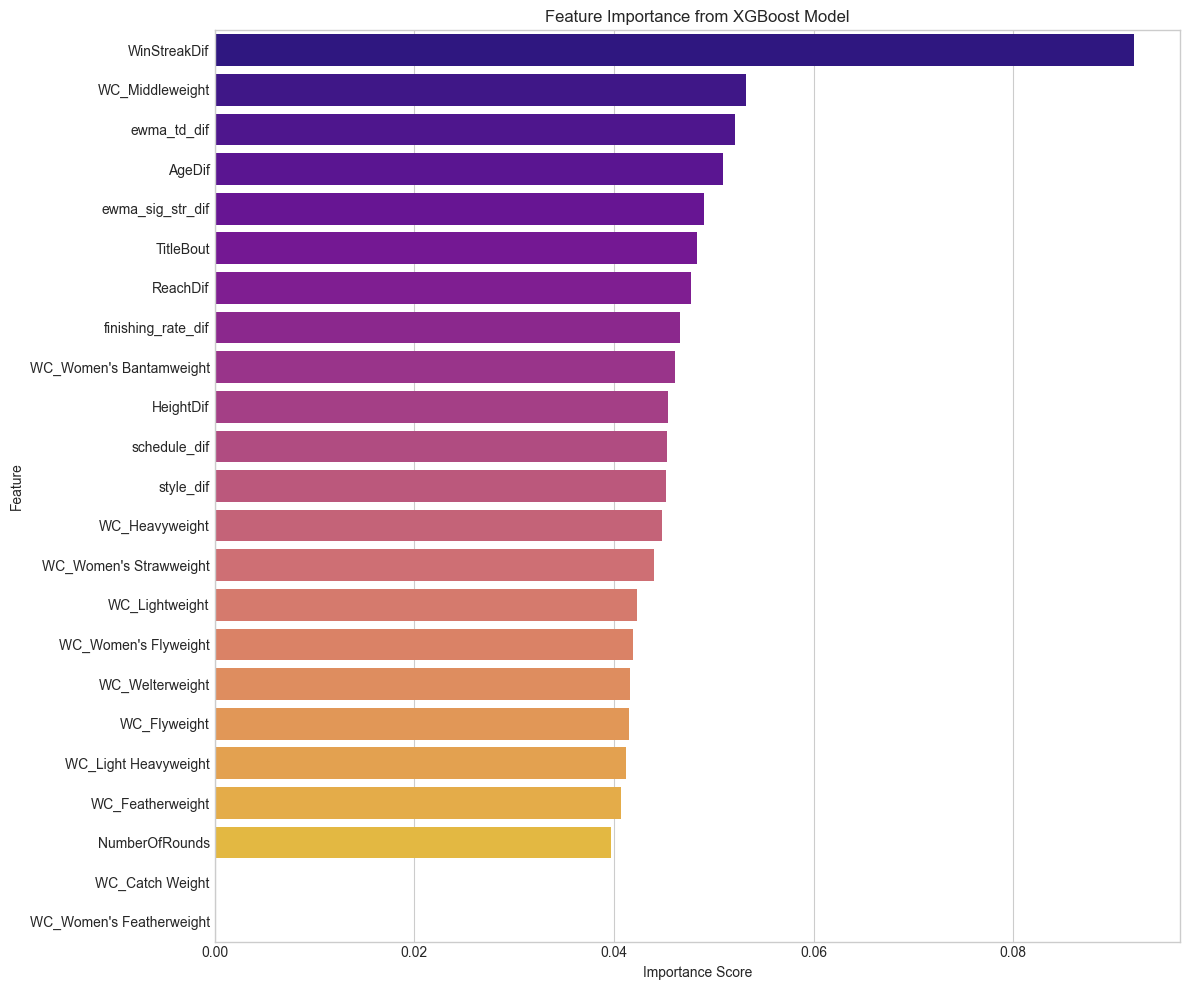

In [7]:
print("--- Model Comparison ---")
print(f"Tuned Random Forest CV Accuracy: {random_search_rf.best_score_:.4f}")
print(f"Tuned XGBoost CV Accuracy:       {random_search_xgb.best_score_:.4f}")

winner_model = best_xgb if random_search_xgb.best_score_ > random_search_rf.best_score_ else best_rf
winner_model_name = "XGBoost" if isinstance(winner_model, xgb.XGBClassifier) else "Random Forest"

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': winner_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='plasma')
plt.title(f'Feature Importance from {winner_model_name} Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()